In [1]:
# Set retina display
%config InlineBackend.figure_format = 'retina'

# X-ray Tomography

In [2]:
import numpy as np
def compute_ray_segment_length(xsrc, ysrc, xrcv, yrcv, xgrid, ygrid):
    ''' 
    Compute segment lengths of a straight ray within crossing grid cells
    Params:
    - xsrc, ysrc: Source coordinates
    - xrcv, yrcv: Receiver coordinates
    - xgrid, ygrid: Grid cell boundaries
    Return:
    - dl_cell: Ray segment lengths in each grid cell
    '''
    ## Determine intersections of the ray to x-grids
    xfrac = (xgrid-xsrc) / (xrcv-xsrc)
    x1 = np.concatenate(([xsrc, xrcv], xgrid[(xfrac>0) & (xfrac<1)]))
    y1 = (yrcv-ysrc) / (xrcv-xsrc) * (x1 - xsrc) + ysrc

    ## Determine intersections of the ray to y-grids
    yfrac = (ygrid-ysrc) / (yrcv-ysrc)
    y2 = ygrid[(yfrac>0) & (yfrac<1)]
    x2 = (xrcv-xsrc) / (yrcv-ysrc) * (y2 - ysrc) + xsrc

    ## Sort intersections point by their distance from the source
    intersections = np.column_stack((np.concatenate((x1, x2)), np.concatenate((y1, y2))))
    dist_from_src = np.sqrt(np.sum((intersections-[xsrc, ysrc])**2, axis=1))
    sorted_intersections = intersections[np.argsort(dist_from_src)]
    segment_midpoints = (sorted_intersections[:-1] + sorted_intersections[1:]) / 2

    ## Assign ray lengths to grid cells
    dl_cell = np.zeros((len(xgrid)-1, len(ygrid)-1))
    ii = np.digitize(segment_midpoints[:, 0], xgrid) - 1
    jj = np.digitize(segment_midpoints[:, 1], ygrid) - 1
    dl_cell[ii, jj] = np.diff(np.sort(dist_from_src))

    return dl_cell.ravel()

def build_Jacobian(src_coords, rcv_coords, xgrid, ygrid):
    ''' 
    Build the Jacobian matrix for straight ray paths given source and receiver coordinates
    Params:
    - src_coords: Source coordinates (N, 2)
    - rcv_coords: Receiver coordinates (N, 2)
    - xgrid: X grid boundaries
    - ygrid: Y grid boundaries
    Return: 
    - Jacobian: Jacobian matrix (number of rays, number of cells)
    '''
    Jacobian = []
    for src, rcv in zip(src_coords, rcv_coords):
        Jacobian.append(compute_ray_segment_length(src[0], src[1], rcv[0], rcv[1], xgrid, ygrid))
    return np.array(Jacobian)

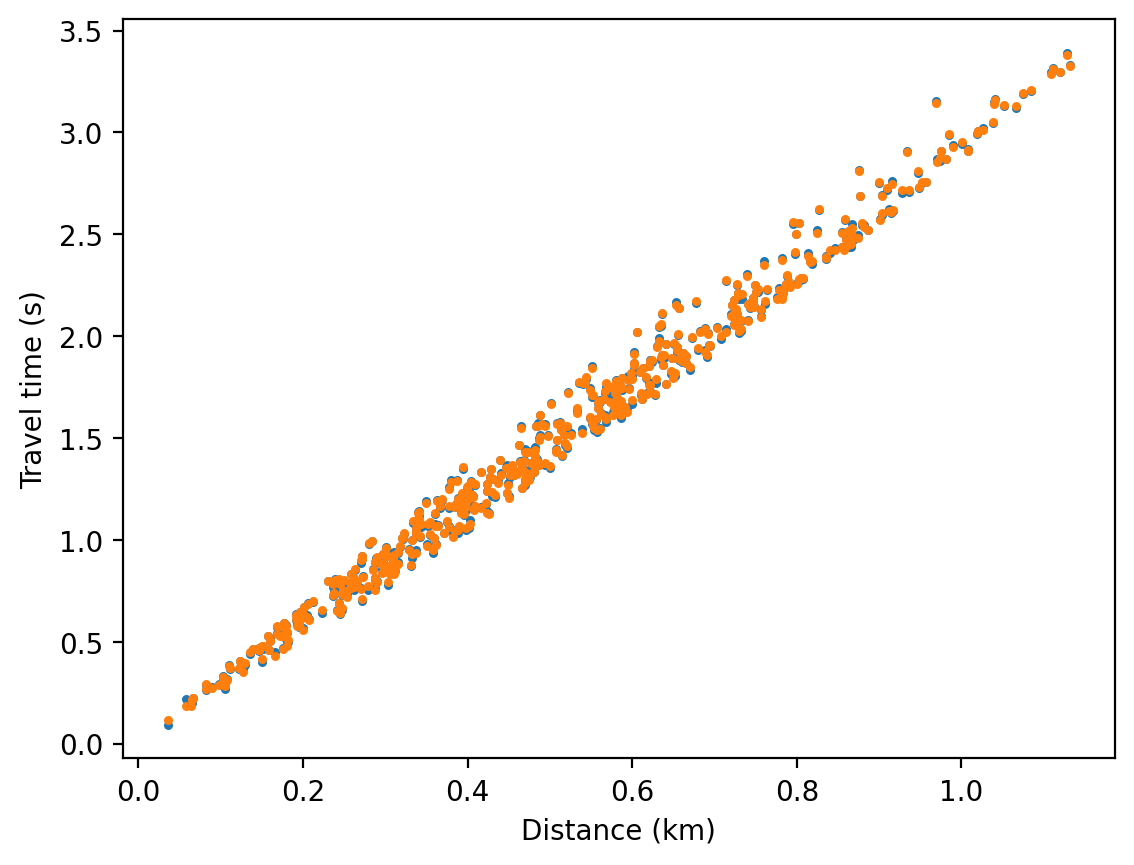

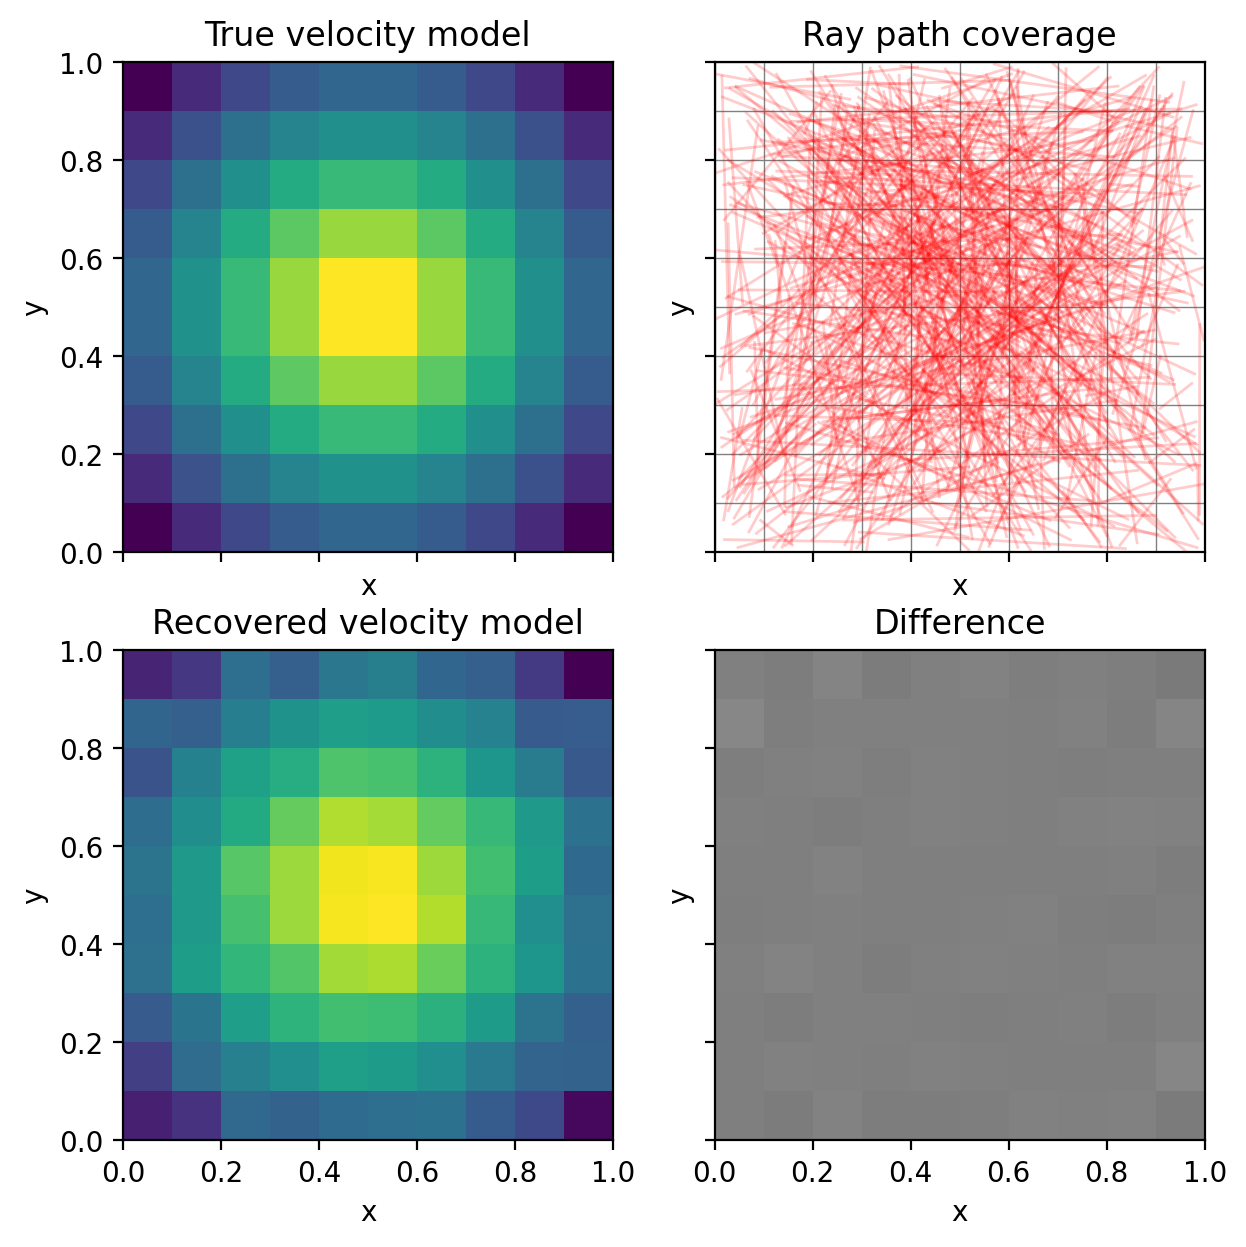

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

## Computation domain
xmin, xmax = 0, 1
xcenter = (xmin + xmax) / 2
ymin, ymax = 0, 1
ycenter = (ymin + ymax) / 2
## Grid cell definition
xgrid = np.linspace(xmin, xmax, 11)
ygrid = np.linspace(ymin, ymax, 11)
## Coordinate of grid cell centers
xmesh, ymesh = np.meshgrid((xgrid[:-1]+xgrid[1:])/2, (ygrid[:-1]+ygrid[1:])/2, indexing='ij')

## Ray crossing to sample the region
nrays = 500
src_coords = np.random.uniform(0, 1, (nrays, 2))
rcv_coords = np.random.uniform(0, 1, (nrays, 2))

## Synthetic input velocity model
vmodel_true = np.zeros_like(xmesh) + .03
vmodel_true = 0.4 - np.sqrt((xmesh-xcenter)**2 + (ymesh-ycenter)**2) * .2

## Input slowness model
smodel_true = 1 / vmodel_true.ravel()

## Build Jacobian matrix and synthetic data
G = build_Jacobian(src_coords, rcv_coords, xgrid, ygrid)
ttime_true = G @ smodel_true
dist_true = np.linalg.norm(rcv_coords - src_coords, axis=1)
## Add noise to synthetic data
sigma = 0.01
ttime_data = ttime_true + np.random.normal(0, sigma, size=ttime_true.shape)

## Recover slowness model
# smodel_inv = np.linalg.inv(G.T @ G) @ G.T @ ttime_data
smodel_inv = np.linalg.pinv(G) @ ttime_data
vmodel_inv = 1 / smodel_inv.reshape(xmesh.shape)
ttime_pred = G @ smodel_inv

## Travel time vs distance
fig0, ax0 = plt.subplots()
ax0.scatter(dist_true, ttime_data, s=5)
ax0.scatter(dist_true, ttime_pred, s=5)
ax0.set(xlabel='Distance (km)', ylabel='Travel time (s)')

## Plot problem setup
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
for _ in ax.flatten():
    _.set(aspect='equal', xlabel='x', ylabel='y', xlim=(xmin, xmax), ylim=(ymin, ymax))
## True input velocity model
ax[0, 0].pcolormesh(xmesh, ymesh, vmodel_true, shading='auto', cmap='viridis', vmin=vmodel_true.min(), vmax=vmodel_true.max())
ax[0, 0].set_title('True velocity model')
## Ray path coverage
for y in ygrid:
    ax[0, 1].hlines(y, xmin=xgrid.min(), xmax=xgrid.max(), color='gray', lw=0.5)
for x in xgrid:
    ax[0, 1].vlines(x, ymin=ygrid.min(), ymax=ygrid.max(), color='gray', lw=0.5)
for src, rcv in zip(src_coords, rcv_coords):
    ax[0, 1].plot([src[0], rcv[0]], [src[1], rcv[1]], color='r', lw=1, alpha=.2)
ax[0, 1].set_title('Ray path coverage')
## Recovered velocity model
ax[1, 0].pcolormesh(xmesh, ymesh, vmodel_inv, shading='auto', cmap='viridis', vmin=vmodel_inv.min(), vmax=vmodel_inv.max())
ax[1, 0].set_title('Recovered velocity model')
## Difference model
ax[1, 1].pcolormesh(xmesh, ymesh, vmodel_inv - vmodel_true, shading='auto', cmap='gray', vmin=-vmodel_true.min(), vmax=vmodel_true.min())
ax[1, 1].set_title('Difference')
plt.show()